# This is the ML Part

So first of all the files need to be loaded from the Data Base

Following is the Calculation of the Influence Score, that needs a swell value. This has to be done by looking up the numbers calculated. 

Third is choosing the number of Clusters

and finally I can Score the Offer types against the Clusters and see how they differ.

In [990]:
import numpy as np
import pandas as pd
import math
import json
from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from kmodes.kprototypes import KPrototypes



from scipy import interpolate

import sqlite3
from sqlalchemy import create_engine

In [991]:
engine = create_engine('sqlite:///data/data.db')


portfolio = pd.read_sql_table ('portfolio', engine)
transcript = pd.read_sql_table ('transcript', engine)
profile = pd.read_sql_table ('profiles', engine)
received_reaction_matrix = pd.read_sql_table ('received_reaction_matrix', engine)

In [992]:
# since I had to save everything as string-type, I do have to reformat the types

transcript ['time in hours'] = transcript['time in hours'].astype (int)
transcript ['amount'] = transcript['amount'].astype (float)
transcript ['count'] = transcript['count'].astype (int)
transcript ['expiration'] = transcript['expiration'].astype (int)
transcript ['DayOfWeek'] = transcript['DayOfWeek'].astype (int)
transcript ['WeekOfMonth'] = transcript['WeekOfMonth'].astype (int)
transcript ['DayOfMonth'] = transcript['DayOfMonth'].astype (int)

received_reaction_matrix ['time in hours'] = received_reaction_matrix['time in hours'].astype (int)
received_reaction_matrix ['amount'] = received_reaction_matrix['amount'].astype (float)
received_reaction_matrix ['count'] = received_reaction_matrix['count'].astype (int)
received_reaction_matrix ['expiration'] = received_reaction_matrix['expiration'].astype (int)
received_reaction_matrix ['DayOfWeek'] = received_reaction_matrix['DayOfWeek'].astype (int)
received_reaction_matrix ['WeekOfMonth'] = received_reaction_matrix['WeekOfMonth'].astype (int)
received_reaction_matrix ['DayOfMonth'] = received_reaction_matrix['DayOfMonth'].astype (int)
received_reaction_matrix ['viewed_yn'] = received_reaction_matrix ['viewed_yn'].astype (int)
received_reaction_matrix ['viewtoexpire'] = received_reaction_matrix ['viewtoexpire'].astype (int)
received_reaction_matrix ['completed_yn'] = received_reaction_matrix ['completed_yn'].astype (int)
received_reaction_matrix ['compacttime'] = received_reaction_matrix ['compacttime'].astype (int)
received_reaction_matrix ['completed_yn_unknown'] = received_reaction_matrix ['completed_yn_unknown'].astype (int)
received_reaction_matrix ['index_received'] = received_reaction_matrix ['index_received'].astype (int)
received_reaction_matrix ['viewedindex_viewed_yn'] = received_reaction_matrix ['index_viewed'].astype (int)
received_reaction_matrix ['index_completed'] = received_reaction_matrix ['index_completed'].astype (int)
received_reaction_matrix ['visits_count'] = received_reaction_matrix ['visits_count'].astype (int)

In [993]:
transcript

,index,person,event,time in hours,amount,count,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,offer_id,expiration,offer_type,DayOfWeek,WeekOfMonth,DayOfMonth
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.00,0,0,0,0,0,...,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,bogo,0,0,0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.00,0,1,0,0,0,...,0,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,discount,0,0,0
2,2,e2127556f4f64592b11af22de27a7932,offer received,0,0.00,0,0,0,1,0,...,0,0,0,0,2906b810c7d4411798c6938adc9daaa5,168,discount,0,0,0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.00,0,0,0,0,0,...,0,0,0,1,fafdcd668e3743c1bb461111dcafc2a4,240,discount,0,0,0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.00,0,0,0,0,0,...,0,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,120,bogo,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297661,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29
297662,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29
297663,306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29
297664,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29


# x.1 Functions

In [994]:
def split_on_event (data):

    '''
        Spliting the data set for better performance

    '''

    received = data [data ['event'] == 'offer received']

    viewed = data [data ['event'] == 'offer viewed']

    completed = data [data ['event'] == 'offer completed']

    transactions = data [data ['event'] == 'transaction']

    return received, viewed, completed, transactions


def offer_per_person (offer_type):
    
    reactions = received_reaction_matrix [received_reaction_matrix ['offer_type'] == offer_type]
    offers = received [received ['offer_type'] == offer_type].groupby ('person')['DayOfMonth'].value_counts ().to_frame().unstack().fillna (0)

    auswahl = ['viewed_yn', 'completed_yn',
           'completed_yn_unknown', 'visits_count']



    offers = offers.merge (reactions.groupby ('person_x')[auswahl].sum(), left_on = offers.index, 
                               right_on =reactions.groupby ('person_x')[auswahl].sum().index).sort_values ('visits_count', ascending = False)
    
    return offers

## Feature Design

Calculating the Influence Score



In [995]:
def get_offer_influence_score (i):
    
    '''
        The influence score of each offer should tell me,
        whether one is likely influenced or is not.
        
        5 terms where calculated
        
        This one is not in the ETL Part, because it can be adjusted and has to be discussed!
    
    '''
    
    try: 
        person = received.set_index ('index').loc [i] ['person']
        index_received = i
        offer_id = received.set_index ('index').loc [i] ['offer_id']
        m = received_reaction_matrix.set_index ('index_received').loc [index_received] ['completed_yn']
        index_completed_return = received_reaction_matrix.set_index ('index_received').loc [index_received] ['index_completed']
        '''
            If an offer is not completed, there is no need to walk through those steps
        '''        
       
    except: 
        m = 0
        index_completed_return = 0
        
    
    try: 
        '''
            This term is for those customers, that are not part of the interquartile range,
            or for another reason are dropped.
            
        '''
        profile.set_index (['id']).loc [person]['count']
        m = received_reaction_matrix.set_index ('index_received').loc [index_received] ['completed_yn']
        index_completed_return = received_reaction_matrix.set_index ('index_received').loc [index_received] ['index_completed']
    except:
        m = 0
        index_completed_return = 0

    
    if m == 1:
        
        '''
            Offer is seen and completed - calculating all the terms
        '''
            
        try: offers_pPerson_received = received [received ['person'] == person].count ()['person']
        except: offers_pPerson_received = 1
    
        try: offers_pPerson_viewed = viewed [viewed ['person'] == person].count ()['person']
        except: offers_pPerson_viewed = 0
            
        count_visits_each_customer = profile.set_index ('id').loc [person]['count']
    
        offer_amount =  portfolio.set_index ('id').loc [offer_id]['difficulty']
        offer_expiration = portfolio.set_index ('id').loc [offer_id]['duration']*24
        median_amount = profile.set_index ('id').loc [person]['50%']
    
        off_react_time = received_reaction_matrix.set_index ('index_received').loc [index_received] ['compacttime']
        view_to_expire = received_reaction_matrix.set_index ('index_received').loc [index_received] ['viewtoexpire']
    
        visits_count = received_reaction_matrix.set_index ('index_received').loc [index_received] ['visits_count']
        
        
        '''
            Term 1: intress in offers
            Offers viewed / num visits
            
            setting a max for this value at 3
        '''
        try: 
            interest = offers_pPerson_viewed / (offers_pPerson_received * 0.75)
            interest = min (2, interest)
            interest = max (0, interest)
        except: freq_visits = 0
        
        
        '''
            Term 2: Percentage money more spent on the offer than median
            
            
        '''
        try: 
            overpay = (offer_amount / (median_amount * 0.66))
            overpay = min (2, overpay)
        except: overpay = 0
        

        
        
        
        '''
            Term 3: attractiveness
            
        '''
        try: 
            attractiveness = (view_to_expire * 0.25) / off_react_time 
            attractiveness = min (2, attractiveness)
            attractiveness = max (0, attractiveness)
        except: attractiveness = 0
       
    
    
        '''
            Term 4: fulfill_by_incident
            the more visits between recognizing the offer and completing it,
            the more unattracted those visits are by the offer itself.
            
        '''
        
        try: 
            fulfill_by_coincident = 1 / (1 * visits_count)
        except: 
            fulfill_by_coincident = 1
        fulfill_by_coincident = min (fulfill_by_coincident, 1)
    
    
        try: influence_score = interest * overpay * attractiveness
        except: influence_score = 0
    
        influence_score_vect = [interest, overpay, attractiveness]

    else: 
        fulfill_by_coincident = 0
        influence_score_vect = [0, 0, 0]
    
        
    return index_completed_return, fulfill_by_coincident, influence_score_vect

# 1. Feature Calculation

In [996]:
received, viewed, completed, transactions = split_on_event (transcript)

In [ ]:
# Calculating the Vector

influence_vect = []
influence_incident = []
influence_ind = []


offer_index = received_reaction_matrix.set_index ('index_received') [received_reaction_matrix.set_index ('index_received') ['completed_yn'].astype (int) == 1].index


i = 0
stop = len (offer_index)

while i < stop:
    
    n = offer_index [i]
    
    index_completed, fulfill_by_coincident, influence_score_vect = get_offer_influence_score (n)
    influence_vect.append (influence_score_vect)
    influence_incident.append (fulfill_by_coincident)
    influence_ind.append (index_completed)
    
    
    print ('%.2f' % (i*100 / stop ), end = '\r')
    
    i += 1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in long_scalars


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in double_scalars


In [977]:
received_reaction_matrix['index_completed'][received_reaction_matrix['index_completed'] >0]

0         32625
5         25737
6         46599
9         47584
10        18068
          ...  
44136    285056
44141    263988
44142    271093
44143    263920
44146    295365
Name: index_completed, Length: 21633, dtype: int64

In [ ]:
received_reaction_matrix.loc [influence_ind]

In [989]:
transactions.amount.describe()

count    89876.000000
mean         5.196150
std          4.105344
min          0.050000
25%          1.700000
50%          3.930000
75%          8.360000
max         14.190000
Name: amount, dtype: float64

In [973]:
pd.DataFrame(influence_ind)[0].sort_values(ascending = False)

15083    306373
15040    306364
17915    306356
16116    306347
17855    306339
          ...  
16329        -1
2535         -1
15783        -1
16317        -1
16723        -1
Name: 0, Length: 18068, dtype: int64

In [974]:
transcript

,index,person,event,time in hours,amount,count,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,offer_id,expiration,offer_type,DayOfWeek,WeekOfMonth,DayOfMonth
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.00,0,0,0,0,0,...,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,bogo,0,0,0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.00,0,1,0,0,0,...,0,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,discount,0,0,0
2,2,e2127556f4f64592b11af22de27a7932,offer received,0,0.00,0,0,0,1,0,...,0,0,0,0,2906b810c7d4411798c6938adc9daaa5,168,discount,0,0,0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.00,0,0,0,0,0,...,0,0,0,1,fafdcd668e3743c1bb461111dcafc2a4,240,discount,0,0,0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.00,0,0,0,0,0,...,0,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,120,bogo,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257452,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29
257453,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29
257454,306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29
257455,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29


# 2. Feature evaluation:


evaluation of the vectors, by looking at the describe tool.

### all three scalars should have a mean around 1
so I have an equal calculation.

The swell value I will calculate by multiplication of all three factors.

In [857]:
pd.DataFrame(influence_vect).describe()

,0,1,2
count,18068.000000,18068.000000,18068.000000
mean,1.074317,1.335495,0.966578
std,0.333962,0.556990,0.781490
min,0.000000,0.000000,0.000000
25%,0.888889,0.914710,0.293958
50%,1.111111,1.327915,0.750000
75%,1.333333,2.000000,2.000000
max,1.333333,2.000000,2.000000


In [858]:
scalar2 = []

i = 0
while i < len (influence_vect):
    y = 1
    for x in pd.DataFrame(influence_vect).iloc [i].sort_values (ascending = False)[:3]:
        y = y * x * pd.DataFrame (influence_incident).iloc [i]
    scalar2.append (y)
    
    print ('%.2f' % (i*100 / len (influence_vect) ), end = '\r')
    
    i += 1

In [859]:
pd.DataFrame(scalar2).describe()

,0
count,18068.000000
mean,1.350659
std,1.364949
min,0.000000
25%,0.078735
50%,0.952381
75%,2.198982
max,5.333333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ddb535c50>]],
      dtype=object)

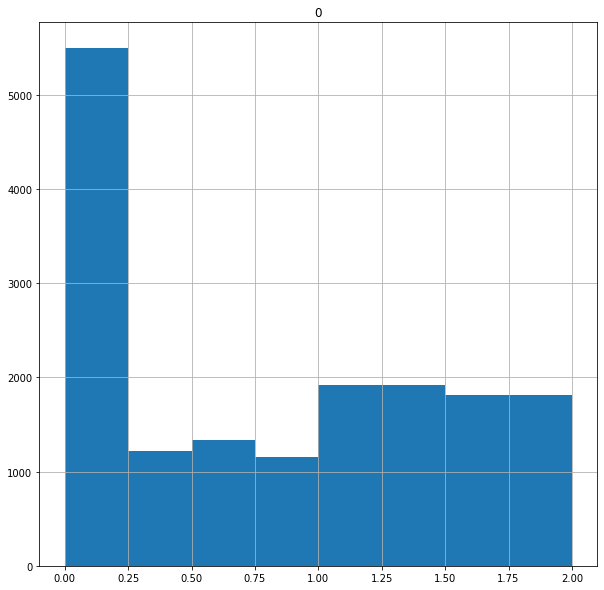

In [860]:
pd.DataFrame(scalar2).hist(bins = [0, 0.25, 0.5, 0.75, 1, 1.5, 2])

# 3. Clustering

I assume that different clusters react to different offer types better or worse


In [861]:
from sklearn import preprocessing

profiles_normalized = profile
Num_features= ['age', 'income', 'member_x_weeks']
profiles_normalized[Num_features]=preprocessing.MinMaxScaler().fit_transform(profiles_normalized[Num_features])

# set the data-types:

profiles_normalized ['gender'] = profiles_normalized.gender.astype (object)
profiles_normalized ['age'] = profiles_normalized.age.astype (float)
profiles_normalized ['id'] = profiles_normalized.id.astype (object)

profiles_normalized ['F'] = profiles_normalized.F.astype (object)
profiles_normalized ['M'] = profiles_normalized.M.astype (object)
profiles_normalized ['O'] = profiles_normalized.O.astype (object)
profiles_normalized ['member_x_weeks'] = profiles_normalized.member_x_weeks.astype (float)

profiles_normalized ['income'] = profiles_normalized.income.astype (float)

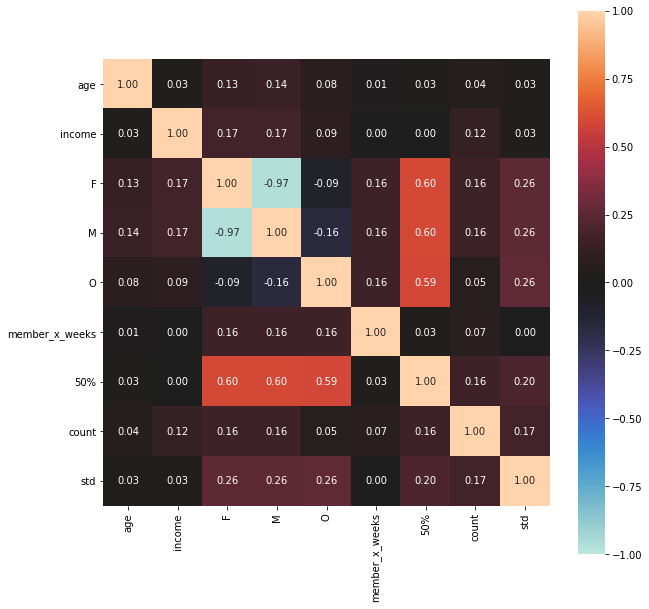

In [862]:
from dython.model_utils import roc_graph
from dython.nominal import associations

def associations_example():
    associations(Data_Correlation, nominal_columns=['age','member_x_weeks', 'income', '50%', 'count', 'std'])
    
    
# data correlation analyzis:


Data_Correlation=profiles_normalized.loc[:, ['age', 'income', 'F', 'M', 'O', 'member_x_weeks', '50%', 'count', 'std']]

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=10, 10
associations_example()

In [863]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [864]:
Data = profiles_normalized [['member_x_weeks', 'income', 'age', '50%', 'count', 'std']]

#Use a random sample of Data for faster computation
#Resetting the indexs
Data=Data.reset_index(drop=True)
#Rename the levels within in the CancellationCode column

Data.columns

#Checking whether data can be clustered
Num_features =Data.select_dtypes(include=[np.number]).columns
hopkins(Data[Num_features])

0.8892697215100411

Hopkins Value is signalizing that the Data is not randomly spread,
and is likely to be clustered

Using the Principal Components Analyzes:

In [865]:
from sklearn.decomposition import PCA

cols = ['age', 'income', 'member_x_weeks', '50%', 'count', 'std']

Data_pca= profiles_normalized [cols]
print (Data_pca.dtypes)

#Principal Component

pca = PCA(n_components= 'mle', whiten=True)

Num_features=Data_pca.select_dtypes(include=[np.number]).columns

x=Data_pca[Num_features]
principalComponents = pca.fit_transform(x)

# Cumulative Explained Variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

print(cum_explained_var)

age               float64
income            float64
member_x_weeks    float64
50%               float64
count             float64
std               float64
dtype: object
[0.738105971024165, 0.9653551184443863, 0.997113743456258, 0.9982189933940543, 0.9992673218498166]


In [866]:
#Principal Components converted to a Data frame


principalDf  = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5'])
principalDf.shape


profiles_pca = pd.concat ([principalDf, profiles_normalized.reset_index()[['F', 'M', 'O', 'index']]], axis = 1)

profiles_pca['F'] = profiles_pca['F'].astype (int)
profiles_pca['M'] = profiles_pca['M'].astype (int)
profiles_pca['O'] = profiles_pca['O'].astype (int)

<function matplotlib.pyplot.show(*args, **kw)>

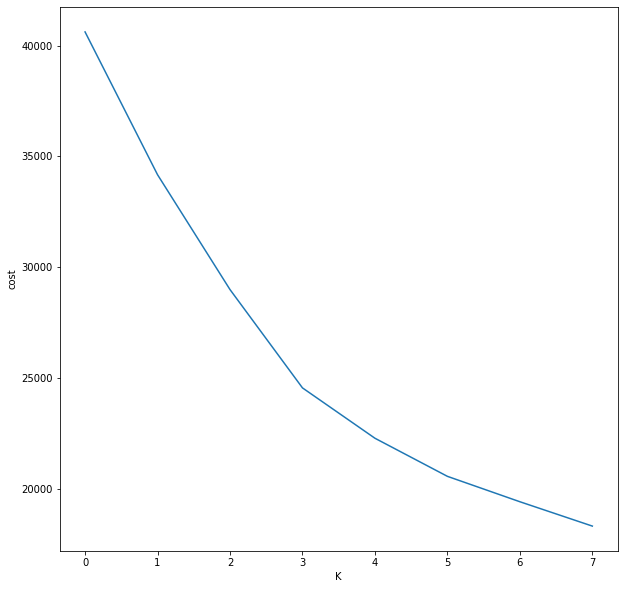

In [328]:
# Attention -- time consuming calculation

from kmodes.kprototypes import KPrototypes

#Choosing optimal K value
cost = []
X = profiles_pca[['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'F', 'M', 'O']]
for num_clusters in list(range(2,10)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=15,n_init=50) 
    kproto.fit_predict(X, categorical=[4, 5, 6])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

Choosing the right amount of Clusters. I end up with 8 (that is K equal to 5)

The number should be as small as possible

0    1650
3    1484
4    1447
7    1416
6    1283
2     749
5     735
1     683
Name: Cluster_id, dtype: int64


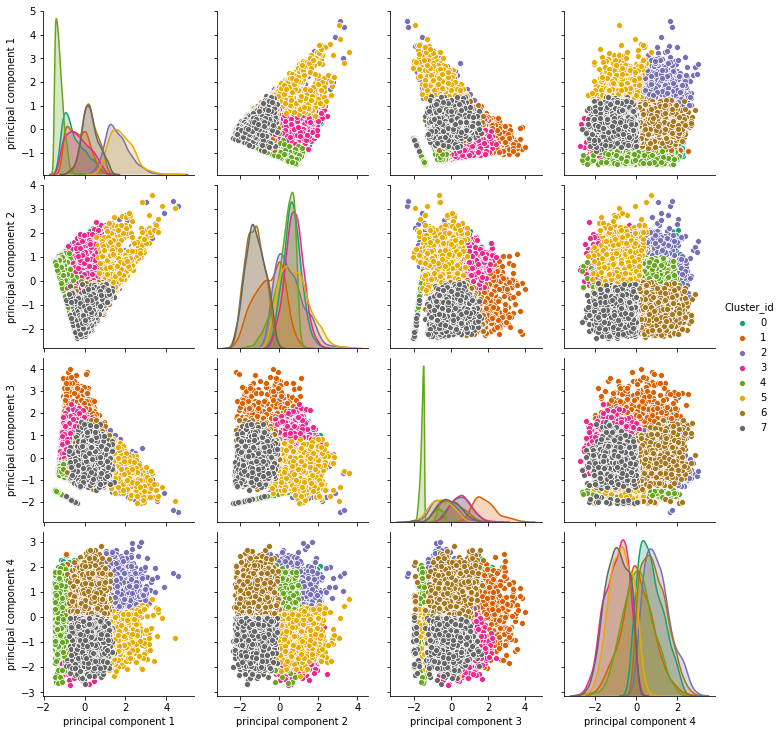

In [867]:
from kmodes.kprototypes import KPrototypes

# number of clusters
k = 8

kproto = KPrototypes(n_clusters=k, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=.25) 
clusters = kproto.fit_predict(profiles_pca[['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 
                                 'F', 'M', 'O']], 
                              categorical =[4, 5, 6])

df=pd.DataFrame(profiles_pca)
df['Cluster_id']=clusters
b = df [['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'Cluster_id']]
print(df['Cluster_id'].value_counts())
sns.pairplot(b,hue='Cluster_id',palette='Dark2',diag_kind='kde')

In [868]:
profiles = profile.merge (b, left_index = True, right_index = True)

# x.2 Functions

In [869]:
def influence_scalar_to_binary (swell_value):
    
    '''
        Decide on what swell the transaction is called influenced
    '''

    i = 0

    influence_yn = []

    while i < len (influence_DF):
        if influence_DF.loc [i][0] >= swell_value:
            influence_yn.append (1)
        else:
            influence_yn.append (0)
        i += 1

    
    influence_bin = influence_DF.merge (pd.DataFrame(influence_yn), left_index = True, right_index = True)
    return influence_bin

In [870]:
def merge_transactions_analyzes ():
    
    '''
        get all data in one DF
    
    '''
    transactions_analyzes_Df = transactions.merge (influence_bin.drop (['0_x'], axis = 1), 
                    how = 'left', left_on = transactions.index, right_on = influence_bin.index)
    
    transactions_analyzes_Df.rename (columns = {'key_0': 'id_completed'}, inplace = True)
    DF = transactions_analyzes_Df.merge (received_reaction_matrix.set_index (['index_completed']).drop ([-1]), 
                                left_on = 'id_completed',
                                right_on = received_reaction_matrix.set_index (['index_completed']).drop ([-1]).index,
                               how = 'left')
    

    cols = ['id_completed', 'index_x', 'person', 'amount_x', 'count_x', '0_y', 'completed_yn', 'completed_yn_unknown', 'offer_type_y']
    
    DF = DF [cols]
    
    return DF

In [871]:
def add_clusters (data):
    
    '''
        Add the found clusters to the transcript
        
        99 is the cluster for not indentified persons.
    '''
    
    i = 0
    cluster = []
    stop = len (data)
    
    while i < stop:
        
        try: cluster.append (profiles.set_index (['id']).loc [data.iloc [i]['person']] ['Cluster_id'])
        except: cluster.append (99)
        
        i += 1
        print ('%.2f' % (i*100 / stop ), end = '\r')
    
    return cluster





In [872]:
def get_offer_value (cluster):
    
    '''
        This is the evaluation:
        
        For each cluster, I will look at the costs (unknown completion) 
        and the value (influenced completion = extra visit). 
    
    '''
    
    cluster_DF = analyzes_DF [analyzes_DF ['cluster'] == cluster].fillna(0)
    
    
    total_sales_count = cluster_DF['amount'].count ()
    total_sales_sum = cluster_DF['amount'].sum ()
    
    # completed unknown (bogo and discount)
    
    unsucc_offer_bogo_count = cluster_DF [cluster_DF ['completed_yn_unknown'] == 1][cluster_DF [cluster_DF ['completed_yn_unknown'] == 1] ['offer_type_y'] == 'bogo']['amount'].count ()
    unsucc_offer_bogo_sum   = cluster_DF [cluster_DF ['completed_yn_unknown'] == 1][cluster_DF [cluster_DF ['completed_yn_unknown'] == 1] ['offer_type_y'] == 'bogo']['amount'].sum ()
    unsucc_offer_discount_count = cluster_DF [cluster_DF ['completed_yn_unknown'] == 1][cluster_DF [cluster_DF ['completed_yn_unknown'] == 1] ['offer_type_y'] == 'discount']['amount'].count ()
    unsucc_offer_discount_sum   = cluster_DF [cluster_DF ['completed_yn_unknown'] == 1][cluster_DF [cluster_DF ['completed_yn_unknown'] == 1] ['offer_type_y'] == 'discount']['amount'].sum ()
    
    # completed (bogo and discount)
    succ_offer_bogo = cluster_DF [cluster_DF ['completed_yn'] == 1][cluster_DF [cluster_DF ['completed_yn'] == 1] ['offer_type_y'] == 'bogo']
    succ_offer_discount = cluster_DF [cluster_DF ['completed_yn'] == 1][cluster_DF [cluster_DF ['completed_yn'] == 1] ['offer_type_y'] == 'discount']
   

    # completed influenced
    influenced_bogo_count = succ_offer_bogo [succ_offer_bogo ['influence bin'] == 1]['amount'].count ()
    influenced_bogo_sum   = succ_offer_bogo [succ_offer_bogo ['influence bin'] == 1]['amount'].sum ()
    influenced_discount_count = succ_offer_discount [succ_offer_discount ['influence bin'] == 1]['amount'].count ()
    influenced_discount_sum  = succ_offer_discount [succ_offer_discount ['influence bin'] == 1]['amount'].sum ()
    
    # completed no-influence
    non_influenced_bogo_count = succ_offer_bogo [succ_offer_bogo ['influence bin'] == 0]['amount'].count ()
    non_influenced_bogo_sum   = succ_offer_bogo [succ_offer_bogo ['influence bin'] == 0]['amount'].sum ()
    non_influenced_discount_count = succ_offer_discount [succ_offer_discount ['influence bin'] == 0]['amount'].count ()
    non_influenced_discount_sum = succ_offer_discount [succ_offer_discount ['influence bin'] == 0]['amount'].sum ()
    
    
    
    
    DF_count = [total_sales_count, unsucc_offer_bogo_count, 
          unsucc_offer_discount_count, influenced_bogo_count, 
         influenced_discount_count, non_influenced_bogo_count,
         non_influenced_discount_count]
    DF_count_name = ['total_sales_count', 'unsucc_offer_bogo_count', 
          'unsucc_offer_discount_count', 'influenced_bogo_count', 
         'influenced_discount_count', 'non_influenced_bogo_count', 
         'non_influenced_discount_count']
    
    DF_sum = [total_sales_sum, unsucc_offer_bogo_sum,
          unsucc_offer_discount_sum, influenced_bogo_sum, 
         influenced_discount_sum,  non_influenced_bogo_sum ,
         non_influenced_discount_sum]
    DF_sum_name = ['total_sales_sum', 'unsucc_offer_bogo_sum',
          'unsucc_offer_discount_sum', 'influenced_bogo_sum', 
         'influenced_discount_sum', 'non_influenced_bogo_sum' ,
         'non_influenced_discount_sum']
    
    DF_count = pd.DataFrame (DF_count, index = DF_count_name)
    
    DF_sum = pd.DataFrame (DF_sum, index = DF_sum_name)
    return DF_count, DF_sum





In [873]:
def get_avg_amount ():
    
    avg = []
    i = 1
    while i < len (DF_sum.index):
        a = DF_sum.index [i]
        b = DF_count.index [i]

        avg.append (DF_sum.loc [a]/DF_count.loc [b])
        i += 1
    return avg
        
    

# Choose a swell value!!

In [874]:
influence_DF = pd.DataFrame(scalar2)

In [890]:
# Choosing a swell value for the scalar.
# I take the Product of the mean values -> something around 1.3

influence_bin = influence_scalar_to_binary (1)
influence_bin['index'] = influence_ind
influence_bin = influence_bin.set_index ('index')

In [912]:
influence_bin['0_y'].value_counts ()

0    9213
1    8855
Name: 0_y, dtype: int64

In [916]:
influence_bin['index'] = influence_ind

In [919]:
influence_bin = influence_bin.set_index ('index')
influence_bin

,0_x,0_y
index,,
32625,0.485625,0
25737,4.000000,1
46599,0.802287,0
18068,0.000000,0
15563,3.168944,1
...,...,...
271335,3.123380,1
0,0.000000,0
271093,1.676795,1


In [956]:
transcript

,index,person,event,time in hours,amount,count,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,offer_id,expiration,offer_type,DayOfWeek,WeekOfMonth,DayOfMonth
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.00,0,0,0,0,0,...,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,bogo,0,0,0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.00,0,1,0,0,0,...,0,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,discount,0,0,0
2,2,e2127556f4f64592b11af22de27a7932,offer received,0,0.00,0,0,0,1,0,...,0,0,0,0,2906b810c7d4411798c6938adc9daaa5,168,discount,0,0,0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.00,0,0,0,0,0,...,0,0,0,1,fafdcd668e3743c1bb461111dcafc2a4,240,discount,0,0,0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.00,0,0,0,0,0,...,0,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,120,bogo,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257452,306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29
257453,306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29
257454,306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29
257455,306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,1,0,0,0,0,...,0,0,0,0,0,714,0,1,4,29


In [957]:
transcript_analyzes = transactions.set_index ('index').merge (influence_bin.merge (pd.DataFrame (influence_ind), left_index = True, right_index = True).set_index ([0])['0_y'], left_index = True, right_index = True, how = 'left')
transcript_analyzes.rename (columns = {'0_y': 'influence bin'}, inplace = True)

# Add Clusters to the trancsript values

In [958]:
columns = ['index', 'gender', 'age', 'id', 'became_member_on',
           'income', 'count', 'mean', 'min', '50%', 'max', 'member_x_weeks',
           'F', 'M', 'O']

profiles = profile[columns].merge (profiles_pca ['Cluster_id'], left_index = True, right_index = True)

profiles

,index,gender,age,id,became_member_on,income,count,mean,min,50%,max,member_x_weeks,F,M,O,Cluster_id
0,0,M,0.643836,389bc3fa690240e798340f5a15918d5c,20180209,0.365079,2.0,10.400000,9.54,10.400,11.26,0.739464,0,1,0,0
1,1,M,0.547945,2eeac8d8feae4a8cad5a6af0499a211d,20171111,0.333333,4.0,3.905000,0.87,3.805,7.14,0.176245,0,1,0,6
2,2,F,0.589041,aa4862eba776480b8bb9c68455b8c2e1,20170911,0.428571,4.0,11.575000,10.08,11.830,12.56,0.222222,1,0,0,0
3,3,M,0.109589,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,0.253968,11.0,5.110909,0.22,5.970,11.58,0.992337,0,1,0,3
4,4,F,0.602740,31dda685af34476cad5bc968bdb01c53,20160211,0.650794,1.0,12.570000,12.57,12.570,12.57,0.049808,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9442,9812,M,0.671233,09a232cdf36d4d2b9d23a860493ce998,20170916,0.095238,14.0,6.872857,2.36,6.455,12.74,0.030651,0,1,0,2
9443,9813,M,0.753425,6a8b0facbdf34e45bbf6d1f82fa6fc79,20160622,0.952381,1.0,13.340000,13.34,13.340,13.34,0.007663,0,1,0,4
9444,9814,M,0.000000,095bc1a9b5f64d0f88ed616df292a3ec,20171118,0.396825,3.0,11.450000,9.80,11.380,13.17,0.298851,0,1,0,3
9445,9815,M,0.465753,acd96146258741999a42ce74856bc119,20140201,0.412698,25.0,3.139600,0.77,2.720,8.64,0.478927,0,1,0,5


In [959]:
transcript_analyzes2 = add_clusters (transcript_analyzes)
pd.DataFrame (transcript_analyzes2, columns = {'cluster'})

analyzes_DF = transcript_analyzes.merge (pd.DataFrame(transcript_analyzes2, columns = {'cluster'}), 
                                         left_index = True, right_index = True)

In [964]:
analyzes_DF

,person,event,time in hours,amount,count,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,...,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,offer_id,expiration,offer_type,DayOfWeek,WeekOfMonth,DayOfMonth,influence bin,cluster
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,99
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,99
12686,bbeb54e861614fc7b22a8844f72dca6c,transaction,0,0.22,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,99
12709,b432b74402bb4981a4651c8df1670365,transaction,0,6.46,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,99
12711,a04fcfd571034456aaa6d56c0a3fd9b6,transaction,0,5.02,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90680,dc307ad4b2994fb08b69af09ebef53dd,transaction,234,11.72,1,0,0,0,0,0,...,0,0,0,234,0,2,1,9,NaN,99
90681,4344c0e231a545769e1bd581d1569d6b,transaction,234,6.54,1,0,0,0,0,0,...,0,0,0,234,0,2,1,9,NaN,99
90682,73acdf97f74e4223a793bee5d26cff7c,transaction,234,3.72,1,0,0,0,0,0,...,0,0,0,234,0,2,1,9,NaN,99
90687,151bf5881ab14c338cca17471db41d6a,transaction,234,1.75,1,0,0,0,0,0,...,0,0,0,234,0,2,1,9,NaN,99


In [960]:
transcript_analyzes

,person,event,time in hours,amount,count,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,...,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,offer_id,expiration,offer_type,DayOfWeek,WeekOfMonth,DayOfMonth,influence bin
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
12686,bbeb54e861614fc7b22a8844f72dca6c,transaction,0,0.22,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
12709,b432b74402bb4981a4651c8df1670365,transaction,0,6.46,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
12711,a04fcfd571034456aaa6d56c0a3fd9b6,transaction,0,5.02,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,1,0,0,0,0,0,...,0,0,0,0,714,0,1,4,29,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,1,0,0,0,0,0,...,0,0,0,0,714,0,1,4,29,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,1,0,0,0,0,0,...,0,0,0,0,714,0,1,4,29,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,1,0,0,0,0,0,...,0,0,0,0,714,0,1,4,29,NaN


In [922]:
# get the offers for each cluster

cluster_received_vect = add_clusters (received)

received_a = received.reset_index ().merge (pd.DataFrame (cluster_received_vect), left_index = True, right_index = True, how = 'left')
received_a.rename (columns = {0: 'cluster'}, inplace = True)

In [923]:
received_a[received_a.offer_type == 'bogo']['cluster'].value_counts()

# send out offers each cluster for type BOGO

99    13596
0      2982
3      2694
4      2531
7      2439
6      2224
5      1495
2      1390
1      1148
Name: cluster, dtype: int64

In [924]:
received_a[received_a.offer_type == 'discount']['cluster'].value_counts()

# send out offers each cluster for type DISCOUNT

99    13491
0      2996
3      2673
7      2557
4      2557
6      2224
5      1438
2      1427
1      1180
Name: cluster, dtype: int64

In [925]:
cols = ['completed_yn', 'compacttime', 'completed_yn_unknown', 'index_received',
       'index_viewed', 'visits_count',
       'viewedindex_viewed_yn', 'offer_type']

analyzes_DF = analyzes_DF.merge (received_reaction_matrix.set_index ('index_completed')[cols], 
                   left_index = True, right_index = True, how = 'left')

# Start of Evaluation

In [926]:
avg = get_avg_amount ()
avg = pd.DataFrame (avg)
avg.rename (index = {0: 'unsucc_offer_bogo', 1: 'unsucc_offer_discount',
       2: 'influenced_bogo', 3:'influenced_discount',
       4: 'non_influenced_bogo', 5: 'non_influenced_discount'}, inplace = True)

In [927]:
bogo_matrix = DF_count.loc [bogo_loc]/ received_a[received_a.offer_type == 'bogo']['cluster'].value_counts()
bogo_matrix

,0,1,2,3,4,5,6,7,99
unsucc_offer_bogo_count,0.021127,0.066202,0.042446,0.024870,0.008297,0.020736,0.076888,0.049200,NaN
influenced_bogo_count,0.052649,0.152439,0.073381,0.079065,0.016989,0.082274,0.174011,0.118491,NaN
non_influenced_bogo_count,0.070087,0.259582,0.166906,0.152561,0.023706,0.161204,0.348022,0.203362,NaN


In [928]:
disc_matrix = DF_count.loc [discount_loc]/ received_a[received_a.offer_type == 'discount']['cluster'].value_counts()
disc_matrix.sort_index (ascending = True)

,0,1,2,3,4,5,6,7,99
influenced_discount_count,0.055073,0.253390,0.137351,0.112982,0.015643,0.075104,0.224371,0.171294,NaN
non_influenced_discount_count,0.102136,0.322881,0.181500,0.134306,0.026985,0.100834,0.276978,0.196324,NaN
unsucc_offer_discount_count,0.028371,0.092373,0.042747,0.046764,0.007822,0.029207,0.094874,0.071568,NaN


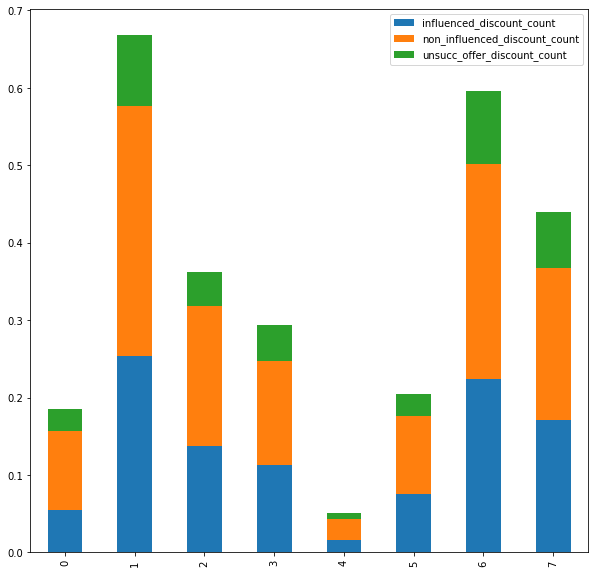

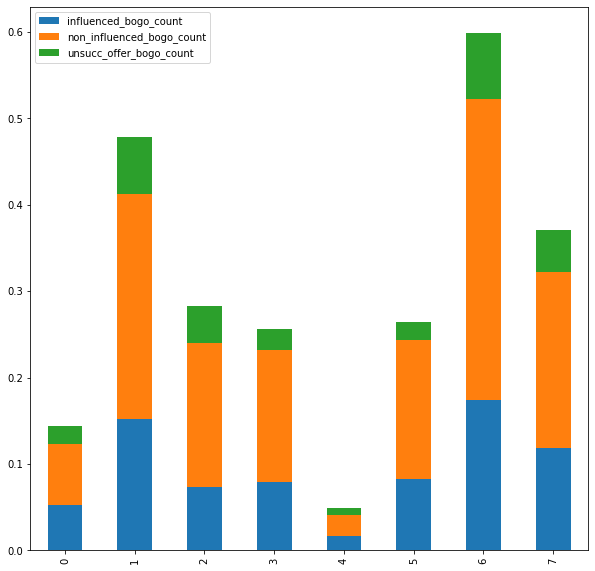

In [929]:
disc_matrix.sort_index (ascending = True).drop ([99], axis = 1).T.plot (kind = 'bar', stacked = True)
bogo_matrix.sort_index (ascending = True).drop ([99], axis = 1).T.plot (kind = 'bar', stacked = True)

In [933]:
analyzes_DF [analyzes_DF ['cluster']== 1][
    analyzes_DF [analyzes_DF ['cluster']== 1]['offer_type_y'] == 'discount'][
    analyzes_DF [analyzes_DF ['cluster']== 1][
    analyzes_DF [analyzes_DF ['cluster']== 1]['offer_type_y'] == 'discount']['influence bin'] == 1
]

,index,person,event,time in hours,amount,count,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,...,influence bin,cluster,completed_yn,compacttime,completed_yn_unknown,index_received,index_viewed,visits_count,viewedindex_viewed_yn,offer_type_y


In [935]:
analyzes_DF [analyzes_DF ['cluster']== 1][
    analyzes_DF [analyzes_DF ['cluster']== 1]['offer_type_y'] == 'discount'][
    analyzes_DF [analyzes_DF ['cluster']== 1][
    analyzes_DF [analyzes_DF ['cluster']== 1]['offer_type_y'] == 'discount']['influence bin'] == 1
]

,index,person,event,time in hours,amount,count,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,...,influence bin,cluster,completed_yn,compacttime,completed_yn_unknown,index_received,index_viewed,visits_count,viewedindex_viewed_yn,offer_type_y


In [939]:
analyzes_DF['influence bin']

Series([], Name: influence bin, dtype: int64)

In [932]:
analyzes_DF [analyzes_DF ['cluster']== 1][
    analyzes_DF [analyzes_DF ['cluster']== 1]['offer_type_y'] == 'bogo'][
    analyzes_DF [analyzes_DF ['cluster']== 1][
    analyzes_DF [analyzes_DF ['cluster']== 1]['offer_type_y'] == 'bogo']['influence bin'] == 1
]['amount'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: amount, dtype: float64

In [ ]:
def  get_cluster_  (cluster, offer_type, influence):
    
    if influence == 1:
        data = analyzes_DF [analyzes_DF ['cluster']== cluster][
            analyzes_DF [analyzes_DF ['cluster']== cluster]['offer_type_y'] == offer_type][
            analyzes_DF [analyzes_DF ['cluster']== cluster][
            analyzes_DF [analyzes_DF ['cluster']== cluster]['offer_type_y'] == offer_type]['influence bin'] ==1
            ]['amount'].describe()
    else: 
        data = analyzes_DF [analyzes_DF ['cluster']== cluster][
            analyzes_DF [analyzes_DF ['cluster']== cluster]['offer_type_y'] == offer_type][
            analyzes_DF [analyzes_DF ['cluster']== cluster][
            analyzes_DF [analyzes_DF ['cluster']== cluster]['offer_type_y'] == offer_type]['influence bin'] !=1
            ]['amount'].describe()
    
    return data
    

In [ ]:
cluste = 1
offer_type = 'bogo'
influence = 1

get_cluster_  (cluster, offer_type, influence)